## Data analysis with Python

Many physical systems can be modeled as an equation, which in Python would be represented by a function $f$. If an appropriate function $f$ can be found for an experiment we can use the equation to determine physical parameters releted to the experiment. For example, Galileo measured the trajectory of a rolling ball to determine the effect of gravity on cannon balls.

If the function $f$ is composed (somehow) of a measurable **independent variable** and some physical parameters, we can measure a **dependent variable** and use the function to find the best parameter values to match the model to the experimental data.

The goal of many lab experiments is to determine the relationship between these two quantities. We control the **independent variable** using the experimental setup (optical glass, power supply, temperature), and measure the **dependent variable** as we change the independent variable. 

## Scipy provides functions that can fit model functions to data.

Scipy provides a number of functions that, given a suitable model function, can return the *best estimate* of the unknown parameters in the model. 

Consider an experiment where the time of flight of an object moving at constant speed is measured. The model in this case relates time and distance $$s=ut$$.

If the experiment is correctly setup. The unknown variable we are trying to determine is the speed $u$. The remaining variables are time $t$ and height $s$. In Python that function might be written as:

In [1]:
def distance(time, speed):
    """Calculate the distance travelled with at a constant speed for a known time."""
    return speed * time

In [52]:

import numpy
measured_times =numpy.arange(10,100,10)#array([10,20,30,40,50,60])
measured_distances = numpy.array([  250.76, 778.24,
                                    1582.76, 2689.03,
                                    4054.68,5717.02, 
                                    7639.46, 9861.82,
                                    12347.873])
distance_errors = numpy.ones_like(measured_distances)*derr

For such a simple model, the average speed can be calculated from the data quite easily.

In [54]:
speeds = measured_distances / measured_times
average_speed = numpy.average(speeds)
print("Average speed is {:.04g} m/s".format(average_speed))
mean_times_error = numpy.std(speeds, ddof=1)/numpy.sqrt(speeds.size)
print("Error in average speed is {:.03g} m/s".format(mean_times_error))

Average speed is 81.11 m/s
Error in average speed is 12.8 m/s


* You can also use `scipy.optimize.curve_fit` to perform this calculation.

In [55]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(distance, measured_times, measured_distances)

print("Average speed is {:.04g} m/s".format(popt[0]))
print("Error in fitted speed is {:.03g} m/s".format(numpy.sqrt(pcov[0,0])))

Average speed is 110.7 m/s
Error in fitted speed is 9.03 m/s


* The above error doesn't consider the erros in the individual data points correctly.
* Give `curve_fit` the error values using the `sigma` keyword, and always use `absolute_sigma=True`

In [56]:
popt, pcov = curve_fit(distance, measured_times, measured_distances,
                       absolute_sigma=True, sigma = distance_errors)
print("Average speed is {:.04g} m/s".format(popt[0]))
print("Error in fitted speed is {:.03g} m/s".format(numpy.sqrt(pcov[0,0])))

Average speed is 110.7 m/s
Error in fitted speed is 0.0296 m/s


* With the correct error estimates, the model is more certain about the speed, but the eastimate of the average speed didn't change.

## The model function needs to follow the `curve_fit` rules
* The function must take and array of **independent data** as its first argument
* The function can take any number of additional parameters that will be found using `curve_fit`
* The function must return a single prediction of the **dependent data** for each value in the independent data.

In [6]:
def good_model_function(xdata, parameter_1, parameter_2, parameter_3):
    # code_that_calculates_a_model
    return prediction

## `curve_fit` works with multiple parameters

Extending the above experiment, assume the object undergoes a constant acceleration. The model function is now

$$ s = ut + \frac{1}{2} at^2$$

where $a$ is the acceleration. With some work we could use algebra to find the value of $u$ and $a$ that fits our data. We can also change the model function and run the `curve_fit` code again

In [7]:
def distance_with_acceleration(time, speed, acceleration):
    """Calculate the distance travelled with at a constant speed for a known time
    and constant acceleration."""
    return speed * time + 0.5 * acceleration * time**2

from scipy.optimize import curve_fit
popt2, pcov2 = curve_fit(distance_with_acceleration, measured_times, measured_distances,
                       absolute_sigma=True, sigma = distance_errors)
print("Initial speed is {:.04g} m/s".format(popt2[0]))
print("Error in fitted speed is {:.03g} m/s".format(numpy.sqrt(pcov2[0,0])))

print("Acceleration is {:.04g} m/s2".format(popt2[1]))
print("Error in fitted acceleration is {:.03g} m/s2".format(numpy.sqrt(pcov2[1,1])))

Initial speed is 10.9 m/s
Error in fitted speed is 0.119 m/s
Acceleration is 2.809 m/s2
Error in fitted acceleration is 0.00325 m/s2


The data use here is fake, generated with an initial speed of 10.86 m/s and an acceleration of 2.81$m/s^2$, but the model with constant speed predicted a much higher speed!

## Challenge 1
How could we have quickly checked whether our model was good?

A plot would have quickly showed the linear model is not correct, or printing each value predicted might tell us something too for small amounts of data.



Text(0,0.5,'Distance (m)')

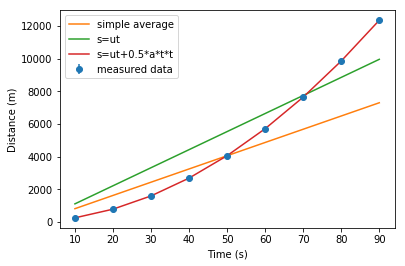

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.errorbar(measured_times, measured_distances,yerr=distance_errors, marker='o', linestyle='none', label="measured data")
plt.plot(measured_times, distance(measured_times, numpy.mean(speeds)),label='simple average')
plt.plot(measured_times, distance(measured_times, popt[0]),label='s=ut')
plt.plot(measured_times, distance_with_acceleration(measured_times, popt2[0],popt2[1]),label='s=ut+0.5*a*t*t')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")

**Always plot your data and model fits.**

## `curve_fit` find the *best estimate* of the parameters using by minimizing **chi squared**.
* Curve fit works by finding the combination of parameters that gives the lowest value of a parameter $\chi^2$, defined as 

$$\chi^2 = \sum\frac{(y_i - f(x_i))^2}{\sigma_{y_i}^2}$$

* The lower the value of $\chi^2$, the closer the model is **on average** to each measured data point.

## **Reduced chi squared** is easier to understand and compare between data sets.
* The value of $\chi^2$ is not constrained to be any particular value for a good model. A related variable $\chi_r^2 = \chi^2/\mathrm{dof}$ is defined such that a the ideal value is 1.0.  
* To get the metric, *dof* is defined as the number of data points - the number of unknown parameters $\mathrm{dof} = N - m$.

* High values of $\chi_r^2$ are bad and suggest the model does a poor job of fitting the data.
* Low values (<1) are also bad, suggesting the model fits the data **too well**
* A low value suggests the model is fitting data better than the average error in the data should allow.

## Calculate predictions using the model function
* `curve_fit` needs a model function to make predictions.
* Any calculations using that model should also use the function to avoid errors
* e.g. when plotting the predictions you should call the model_function, *and not rewrite the equation*

Text(0,0.5,'Distance (m)')

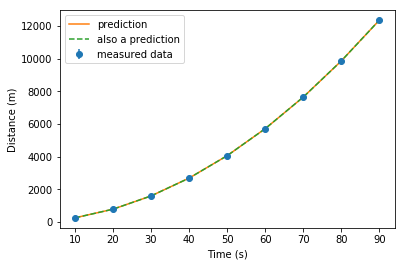

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.errorbar(measured_times, 
             measured_distances,
             yerr=distance_errors,
             marker='o', linestyle='none', label="measured data")

plt.plot(measured_times, 
         distance_with_acceleration(measured_times, popt2[0],popt2[1]),
         label='prediction')

plt.plot(measured_times, 
         popt2[0]*measured_times + 0.5 * popt2[1]* measured_times**2,
         label='also a prediction',ls='--')

#what happens if I change the model function!

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")

In [47]:
def chi2(y_measure,y_predict,errors):
    """Calculate the chi squared value given a measurement with errors and prediction"""
    return numpy.sum( (y_measure - y_predict)**2 / errors**2)

def chi2reduced(y_measure, y_predict, errors, number_of_parameters):
    """Calculate the reduced chi squared value given a measurement with errors and prediction,
    and knowing the number of parameters in the model."""
    return chi2(y_measure, y_predict, errors)/(y_measure.size - number_of_parameters)

In [75]:
print("Constant velocity model chi2r=",chi2reduced(measured_distances, 
                                        distance(measured_times,popt[0]),
                                        distance_errors,
                                        1))

print("Constant acceleration model chi2r=",chi2reduced(measured_distances, 
                                        distance_with_acceleration(measured_times,popt2[0],popt2[1]),
                                        distance_errors,
                                        2))

Constant velocity model chi2r= 92991.0149726342
Constant acceleration model chi2r= 1.3229067130140824


## Non-linear regression
* Mathematically, `curve_fit` is using *least squared error regression* to find the best parameter estimate. 
* The error estimates it provides are strictly for linear regression only (e.g. $a=bx+c$)
* `curve_fit` works with non linear model (e.g. $a=b*c*x+c$) and the error estimates are usually correct.

# `curve_fit` returns the best estimate and the error in the estimate.
* `curve_fit` returns *popt*, an array of estimates of the parameters
* `curve_fit` returns *pcov*, an 2 dimensional array of error covariances.
  * The diagonal of the covariance matrix are the variances on each element. Taking the square root gives you the standard deviation of the parameter estimate.

## Challenge 2
Put a print statement inside the model function `distance_with_acceleration` to print out the parameter values. What is happening to the parameter values?

In [254]:
def distance_with_acceleration(time, speed, acceleration):
    """Calculate the distance travelled with at a constant speed for a known time
    and constant acceleration."""
    print ("speed=",speed, "acceleration=",acceleration)
    return speed * time + 0.5 * acceleration * time**2

popt2, pcov2 = curve_fit(distance_with_acceleration, measured_times, measured_distances,
                       absolute_sigma=True, sigma = distance_errors)


speed= 1.0 acceleration= 1.0
speed= 1.0 acceleration= 1.0
speed= 1.0 acceleration= 1.0
speed= 1.0000000149011612 acceleration= 1.0
speed= 1.0 acceleration= 1.0000000149011612
speed= 11.109633928593492 acceleration= 2.802648214289646
speed= 11.109634094139938 acceleration= 2.802648214289646
speed= 11.109633928593492 acceleration= 2.802648256052359
speed= 11.109633926584204 acceleration= 2.802648214357316


## When fitting non-linear functions, use the `p0` keyword to start `curve_fit` with a good estimate
* `p0` is used to provide a first guess of the parameters you are trying to find
* If you have some idea of a parameter value, use `p0` to give `curve_fit` a better chance of finding the global minimum error for non-linear functions
* Don't be too precise so as not to bias the fitting process.

In [307]:
iteration=0
def nonlinear_function(t, a, b, c):
    global iteration
    print (iteration, "a=",a, "b=",b, "c=",c)
    iteration = iteration+1
    return a*t**(b-1) + c

t=numpy.arange(10)
y=numpy.array([-0.173, 2.12, 9.42, 19.69, 37.16, 59.40, 96.59, 119.448, 158.0,201.9])
sigmaNL = numpy.ones(10)*0.5

First, try fitting the non-linear function with no initial guess

In [309]:
iteration=0
poptNL1, pcovNL1 = curve_fit(nonlinear_function, t, y,
                       absolute_sigma=True, sigma = sigmaNL)

0 a= 1.0 b= 1.0 c= 1.0
1 a= 1.0 b= 1.0 c= 1.0
2 a= 1.0 b= 1.0 c= 1.0
3 a= 1.0000000149011612 b= 1.0 c= 1.0
4 a= 1.0 b= 1.0000000149011612 c= 1.0
5 a= 1.0 b= 1.0 c= 1.0000000149011612
6 a= 77.19199892187382 b= 1.000001167729559 c= 1.0
7 a= 77.19200007212423 b= 1.000001167729559 c= 1.0
8 a= 77.19199892187382 b= 1.0000011826307376 c= 1.0
9 a= 77.19199892187382 b= 1.000001167729559 c= 1.0000000149011612
10 a= 78.36447902457489 b= 1.0000087185633595 c= -0.17339350031973977
11 a= 78.36448019229663 b= 1.0000087185633595 c= -0.17339350031973977
12 a= 78.36447902457489 b= 1.0000087334646506 c= -0.17339350031973977
13 a= 78.36447902457489 b= 1.0000087185633595 c= -0.17339349773597526
14 a= 78.36575304520085 b= 1.000023821040081 c= -0.1760675336783647
15 a= 78.36575421294157 b= 1.000023821040081 c= -0.1760675336783647
16 a= 78.36575304520085 b= 1.0000238359415972 c= -0.1760675336783647
17 a= 78.36575304520085 b= 1.000023821040081 c= -0.176067531054754
18 a= 78.36829338606314 b= 1.000054025993526 

Now try an unreasonable guess for the `b` parameter

In [310]:
iteration = 0
poptNL2, pcovNL2 = curve_fit(nonlinear_function, t, y,
                       absolute_sigma=True, sigma = sigmaNL, p0=(3,-2,0.1))

0 a= 3.0 b= -2.0 c= 0.1
1 a= 3.0 b= -2.0 c= 0.1
2 a= 3.0 b= -2.0 c= 0.1
3 a= 3.0000000447034836 b= -2.0 c= 0.1
4 a= 3.0 b= -1.9999999701976776 c= 0.1
5 a= 3.0 b= -2.0 c= 0.10000000149011612


/Users/lee/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in power
/Users/lee/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


And a better guess

In [311]:
iteration = 0
poptNL3, pcovNL3 = curve_fit(nonlinear_function, t, y,
                       absolute_sigma=True, sigma = sigmaNL, p0=(2.5,2,0))
#I think it's 2.5*t^2 with no offset

0 a= 2.5 b= 2.0 c= 0.0
1 a= 2.5 b= 2.0 c= 0.0
2 a= 2.5 b= 2.0 c= 0.0
3 a= 2.500000037252903 b= 2.0 c= 0.0
4 a= 2.5 b= 2.0000000298023224 c= 0.0
5 a= 2.5 b= 2.0 c= 1.4901161193880158e-08
6 a= -12.495082996475169 b= 8.071074459093417 c= 6.593167925528919
7 a= 4.637250530915298 b= 2.4699836788262353 c= 7.334677140023901
8 a= 4.637250600015716 b= 2.4699836788262353 c= 7.334677140023901
9 a= 4.637250530915298 b= 2.46998371563186 c= 7.334677140023901
10 a= 4.637250530915298 b= 2.4699836788262353 c= 7.334677249319108
11 a= 4.935393822240517 b= 2.7628282595060485 c= -7.605506615823115
12 a= 4.935393895783616 b= 2.7628282595060485 c= -7.605506615823115
13 a= 4.935393822240517 b= 2.7628283006753978 c= -7.605506615823115
14 a= 4.935393822240517 b= 2.7628282595060485 c= -7.6055065024922355
15 a= 2.0938194359937965 b= 2.9572089548281797 c= -0.5231729173581963
16 a= 3.7737847996226686 b= 2.8042833017333217 c= -5.169482604829221
17 a= 3.773784855856444 b= 2.8042833017333217 c= -5.169482604829221
18 a

It's always important to **check the fit**

46 a= 2.5074210685973637 b= 2.999031031902325 c= -0.9734725519528605
47 a= 3.0 b= -2.0 c= 0.1
48 a= 2.507421483361269 b= 2.999030961024037 c= -0.9734752948145166


/Users/lee/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in power


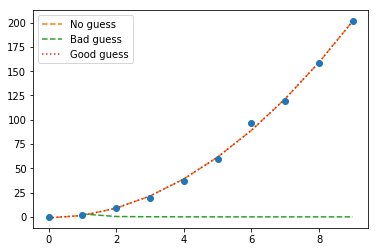

In [312]:
plt.errorbar(t, 
             y,
             yerr=sigmaNL, marker='o',ls='none')

def plot_and_print(popt,ls,label):
    plt.plot(t, nonlinear_function(t,popt[0],popt[1],popt[2]),label=label,ls=ls)
plot_and_print(poptNL1,"--","No guess")
plot_and_print(poptNL2,"--","Bad guess")
plot_and_print(poptNL3,":","Good guess")

plt.legend()



## Keypoints
* `scipy` provides tools and functions to fit models to data.
* Use `curve_fit` to fit linear and non-linear models to experimental data
* Use appropriate errors in the `sigma` keyword to get a better estimate of parameter errors.
* **Check the fit** using a plot if possible
* Check the $\chi_r^2$ value to compare the fit against the errors in the measurements.
* Non linear models can be fitted, but may need an initial esimate of the parameters.